<a href="https://colab.research.google.com/github/arunangshudutta/EE5121_assignment_2/blob/main/Prob_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os
import pandas

### Loading data

In [2]:
Phi_df = pandas.read_csv('Phi_Q1.csv')
mu_df = pandas.read_csv('mu_Q1.csv')

In [3]:
Phi = Phi_df.values
Phi = Phi[:,1:]
mu = mu_df.values
mu = mu[:,1:]

In [4]:
print("Phi matrix")
print(Phi)
print(np.transpose(Phi).shape)

Phi matrix
[[0.9204855992226304 0.0606087856506495]
 [1.026893500756563 0.7233076335673176]
 [0.2456417506493272 1.058182052689436]
 [-0.4222006360386848 1.116496117366269]
 [-0.7226279093448724 0.6411385546593056]
 [-0.8309003385084712 -0.0952608574910851]
 [-0.7958524386608704 -0.6581741866155422]
 [-0.1794378382908305 -0.7161527131140543]
 [0.2668553036297661 -1.16644281465737]
 [0.8653146419024282 -0.6445685646185153]]
(2, 10)


In [5]:
print("mu")
print(mu)
print(np.transpose(mu).shape)

mu
[[0.0668174248822107 0.2264964761374481]]
(2, 1)


# Question 1 (e)

In [6]:
def projection_func(y, Phi, mu, x0=None):

  # convex QP
  def proj_obj(v):
    return 0.5*np.sum((v - y)**2)

  if x0 is None:
    x0 = np.maximum(y, 1e-8)
    x0 = x0 / x0.sum()


  #  moment constraint (Phi^T)*v = mu
  #  simplex constraint (1^T)*v = 1

  cons = [{'type': 'eq', 'fun': lambda v: float(np.dot(Phi[:, 0], v) - mu[0,0])},
          {'type': 'eq', 'fun': lambda v: float(np.dot(Phi[:, 1], v) - mu[0,1])},
          {'type': 'eq', 'fun': lambda v: float(np.sum(v) - 1.0)}]

  # inequality constrain: p(i) >= 0
  for i in range(10):
    cons.append({'type': 'ineq', 'fun': lambda v, i=i: float(v[i])})


  bounds = [(0.0, None)] * 10

  # SLSQP optimizer initilazation
  res = minimize(proj_obj, x0, method='SLSQP', bounds=bounds, constraints=cons,
                   options={'ftol':1e-10, 'maxiter':1000, 'iprint':0})
  if not res.success:
    print("Projection solver warning:", res.message) # error point

  # optimizer result
  v = res.x

  return v

def entropy(p):
  h = 0
  for i in range(10):
    h = h + p[i]*np.log(np.maximum( p[i] , 1e-12 ))
  return -h

In [9]:
N_itter = 100         # iterations
alpha = 0.01           # primal step size (tune as needed)
eps = 1e-12           # for log stability

# random initialization
u = np.random.rand(10)
u = u / np.sum(u)
#p0 = projection_func(u, Phi, mu, x0=u)


p_k = u.copy()

H_hist = []
res_mom_hist = []
res_sum_hist = []

for t in range(N_itter):

    # save all the data
    H_hist.append(entropy(p_k))
    res_mom_hist.append(np.linalg.norm(Phi.T @ p_k - mu))
    res_sum_hist.append(abs(np.sum(p_k) - 1.0))

    # gradient: - (log p + 1)
    grad = - (np.log(np.maximum(p_k, eps)) + 1.0)
    y = p_k + alpha * grad

    # projection (solve QP)
    p_next = projection_func(y, Phi, mu, x0=p_k)
    p_k = p_next

H_hist.append(entropy(p_k))
res_mom_hist.append(np.linalg.norm(Phi.T @ p_k - mu))
res_sum_hist.append(abs(np.sum(p_k) - 1.0))

In [14]:
print('The optimal value H(p*) = ', H_hist[-1])

The optimal value H(p*) =  2.2700535294230257


### Plots

Text(0.5, 1.0, '$H(p_k)$ versus iteration $k$')

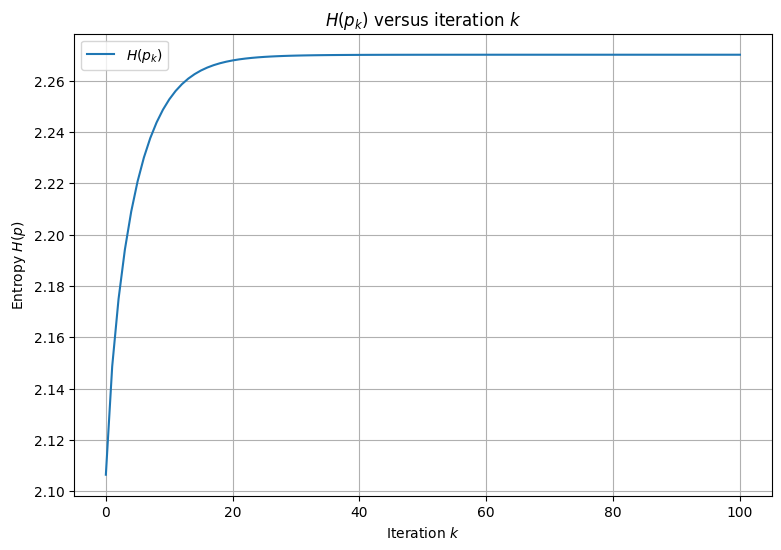

In [10]:
it = np.arange(len(H_hist))

plt.figure(figsize=(9,6))
plt.grid(True)
plt.plot(it, H_hist, label="$H(p_k)$")
plt.ylabel("Entropy $H(p)$")
plt.xlabel("Iteration $k$")
plt.legend()
plt.title("$H(p_k)$ versus iteration $k$")

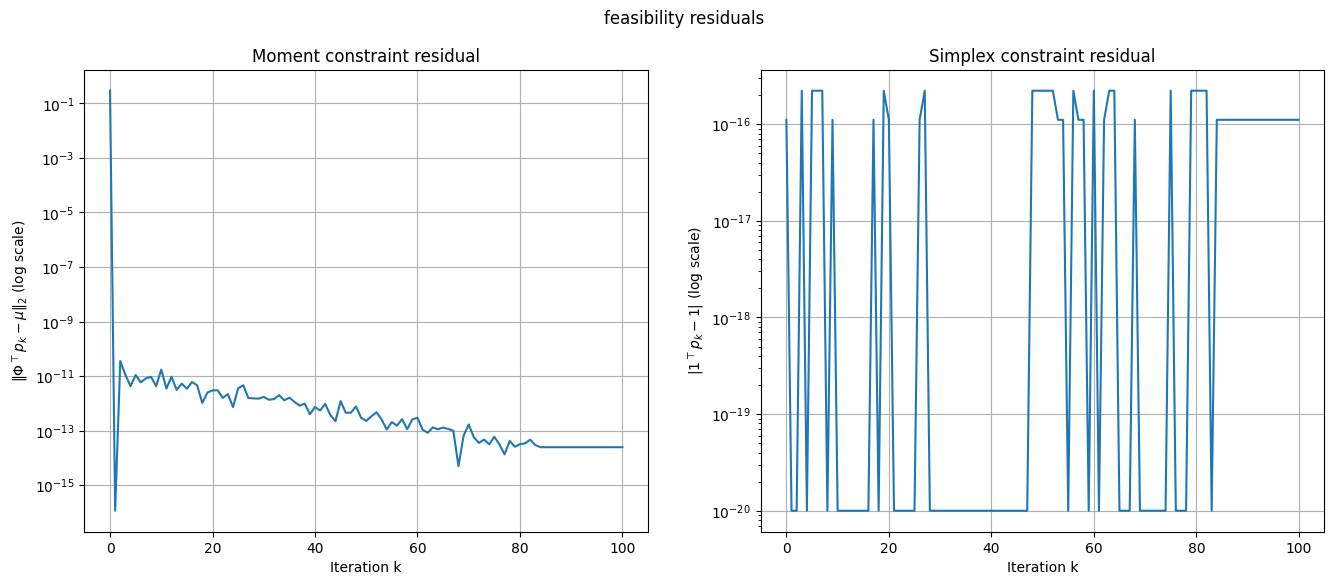

In [15]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axs[0].grid(True)
axs[0].semilogy(it, np.array(res_mom_hist)+1e-20)
axs[0].set_ylabel(r"$\|\Phi^\top p_k - \mu\|_2$ (log scale)")
axs[0].set_xlabel("Iteration k")
axs[0].set_title("Moment constraint residual")

axs[1].grid(True)
axs[1].semilogy(it, np.array(res_sum_hist)+1e-20)
axs[1].set_ylabel(r"$|1^\top p_k -1|$ (log scale)")
axs[1].set_xlabel("Iteration k")
axs[1].set_title("Simplex constraint residual")

fig.suptitle("feasibility residuals")
plt.show()

# Question 1 (f)

In [16]:
n = 10
k = 2

Phi = Phi_df.values
Phi = Phi[:,1:].astype(float)
mu = mu_df.values
mu = mu[:,1:].astype(float)
mu = mu.reshape(-1)

def neg_g(params):
    theta = np.array(params[:k], dtype=float)
    nu = float(params[-1])

    # Compute safely using numpy arrays
    linear_terms = Phi @ theta + nu  # shape (n,)
    exp_terms = np.exp(-(1.0 + linear_terms))  # vectorized exp
    g = -np.sum(exp_terms) - theta @ mu - nu
    return -g  # minimize negative to maximize g

# Initial guess ------------------------------------------------------
x0 = np.zeros(k + 1, dtype=float)

# Optimization -------------------------------------------------------
res = minimize(neg_g, x0, method='BFGS')

# Results ------------------------------------------------------------
theta_opt = res.x[:k]
nu_opt = res.x[-1]

print("Optimal theta:", theta_opt)
print("Optimal nu:", nu_opt)
print("Maximum value g(theta, nu):", res.fun)

Optimal theta: [-0.06250214 -0.32719739]
Optimal nu: 1.3483385317128502
Maximum value g(theta, nu): 2.2700535917029043


In [24]:
p_dual = []

for i in range(n):
  linear_terms = np.sum(np.dot(theta_opt, Phi[i,:]))
  p_dual.append(np.exp(-(1.0 + linear_terms + nu_opt)))


In [30]:
# infinite norm
print("The array | p_dual - p_primal| = ", abs(p_dual - p_k))
print("Infinite norm is = ", max(abs(p_dual - p_k)))

The array | p_dual - p_primal| =  [5.87311053e-06 2.28540021e-05 8.95096495e-05 8.60352735e-05
 2.61371655e-05 4.31738030e-06 1.76717129e-06 1.44400192e-06
 1.59278342e-06 3.58442702e-06]
Infinite norm is =  8.950964948320483e-05


In [31]:
# duality gap
print("The array |H(p*) - g(theta*, nu*)| = ", abs(H_hist[-1] - res.fun))

The array |H(p*) - g(theta*, nu*)| =  6.22798785876455e-08
